# Granger Causality with Google Trends - Did `itaewon class` cause `โคชูจัง`?

In [73]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rc('font', family='Ayuthaya') # MacOS

In [74]:
#get trend objects with thailand offset 7*60 = 420 minutes
trend = TrendReq(hl='th-TH', tz=420)

In [75]:
#compare 2 keywords
kw_list = ['โคชูจัง','itaewon class']
trend.build_payload(kw_list, geo='TH',timeframe='2020-01-01 2020-04-30')
df = trend.interest_over_time().iloc[:,:2]
df.head()

,โคชูจัง,itaewon class
date,,
2020-01-01,2,0
2020-01-02,1,0
2020-01-03,1,0
2020-01-04,3,0
2020-01-05,3,0


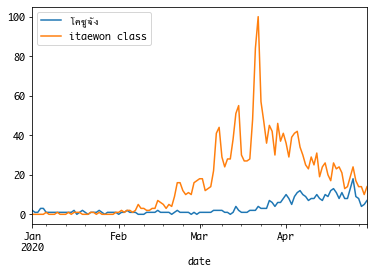

In [76]:
df.plot()

In [77]:
#test for stationarity with augmented dickey fuller test
from statsmodels.tsa.stattools import adfuller
test_stat0, p_value0, nb_lag10, _, _, _ = adfuller(df.iloc[:,0])
test_stat1, p_value1, nb_lag1, _, _, _ = adfuller(df.iloc[:,1])

In [78]:
#definitely non-stationary
p_value0, p_value1

(0.9576156428083366, 0.6046612180774141)

In [79]:
diff_df = df.diff(1).dropna()
test_stat0, p_value0, nb_lag10, _, _, _ = adfuller(diff_df.iloc[:,0])
test_stat1, p_value1, nb_lag1, _, _, _ = adfuller(diff_df.iloc[:,1])

In [80]:
#difference is better non-stationary
p_value0, p_value1

(4.958019203682349e-16, 6.9070426580201e-05)

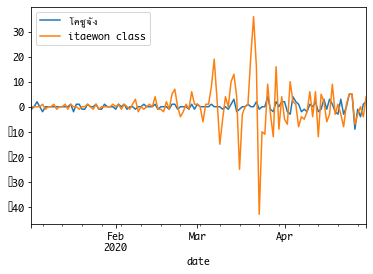

In [81]:
diff_df.plot()

In [82]:
from statsmodels.tsa.stattools import grangercausalitytests

#sample with max lags up to 7, 14, 21, 28
#null hypothesis: the coefficients corresponding to past values of the second time series are zero.
res = grangercausalitytests(diff_df, maxlag=[7, 14, 21, 28])


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5681  , p=0.7802  , df_denom=98, df_num=7
ssr based chi2 test:   chi2=4.5854  , p=0.7104  , df=7
likelihood ratio test: chi2=4.4948  , p=0.7213  , df=7
parameter F test:         F=0.5681  , p=0.7802  , df_denom=98, df_num=7

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=1.0181  , p=0.4449  , df_denom=77, df_num=14
ssr based chi2 test:   chi2=19.6207 , p=0.1426  , df=14
likelihood ratio test: chi2=18.0017 , p=0.2067  , df=14
parameter F test:         F=1.0181  , p=0.4449  , df_denom=77, df_num=14

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=5.5867  , p=0.0000  , df_denom=56, df_num=21
ssr based chi2 test:   chi2=207.4045, p=0.0000  , df=21
likelihood ratio test: chi2=111.8488, p=0.0000  , df=21
parameter F test:         F=5.5867  , p=0.0000  , df_denom=56, df_num=21

Granger Causality
number of lags (no zero) 28
ssr based F test:         F=4.4849  , p=0.0

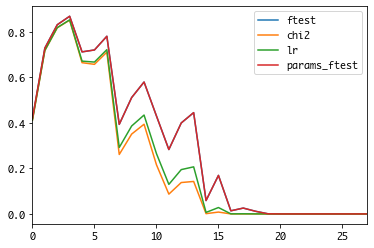

In [83]:
#find the optimal lag
lags = list(range(1,29))
res = grangercausalitytests(diff_df, maxlag=lags, verbose=False)
p_values = []
for i in lags:
    p_values.append({'maxlag':i,
                    'ftest':res[i][0]['ssr_ftest'][1], 
                    'chi2':res[i][0]['ssr_chi2test'][1],
                    'lr':res[i][0]['lrtest'][1],
                    'params_ftest':res[i][0]['params_ftest'][1],})
p_df = pd.DataFrame(p_values)
p_df.iloc[:,1:].plot()